# Assignment 2: Cell Tower Installation

## Instructions

This assignment is worth 10/100 points. 

You can do this assignment with someone else and it is about Local Search Algorithms, more specifically, Genetic Algorithms.

Answer to all the questions in english, argument, and justify your answers using the obtained results.

### Names

- Nicolas Cari Rodriguez
- Christian Rivero Arnez

### Deadline
March 18th, 2023 at 23.59

### Some more Instructions
- You need to fill in your answers here and submit this jupyter notebook via NEO.
- It should run smoothly.
- Any compilation error will affect your total score. 


### Important before starting! 

- Only one of you should send the assignment, NOT BOTH!
- DO NOT copy the answers from internet nor from your classmates.
- If there are two or more groups that were discovered cheeting, then they will be penalized with 0/10.
- Use your brain and the material seen in class to program this assignment.
- You should be able to explain and modify your code according to your (or my) needs. 

## Problem Description
A local cellphone bolivian company wants to give cell phone signal to $n$ cities located in a remote place somewhere in Bolivia. 

They want to install cell towers that gives signal for $r$ Km around. The cost of installing a tower on land is not the same as the cost of installing it on a lake or on top of a hill. Thus, they want to minimize the amount of towers to be used and also the cost to be spent by installing each of them while giving signal to all cities (total coverage) such as in the picture below where we can see that all cities are covered. 

<div>
<img src="img/cities.png" width="500"/>
</div>


We will suppose that the signal radius of each tower is the same, independently if the tower is on top of a hill or on the land. 

### Some code to help you focus on the important part

We have already implemented part of the code to help you deal with some aspects of the problem such as the map representation, the cell tower coverage, part of the chromosome representation. 

In [1]:
import numpy as np
import random
from enum import Enum, auto
import copy
from matplotlib import colors, pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [2]:
class Chromosome: 
    rows = 0 
    cols = 0
    
    def __init__(self, gens):
        self.gens = gens
        self.FitnessValue=0
        # fitness function can be defined outside the class
        #self.ind_fitness = self.__class__.fitness_function(self.get_coordinates())
    def __gt__(self,otherChromosome):
        return self.FitnessValue>otherChromosome.FitnessValue
    @classmethod
    def generate_random(cls, tower_pr):
        '''
            It generates a random chromosome
            tower_pr is the probability to add a tower to a certain position
            higher this amount more towers you will have
            lower this amount less towers you will have
        '''
        gens = [0] * cls.rows * cls.cols 
        for i in range(cls.rows * cls.cols): 
            if random.random() < tower_pr:
                # indicates the presence of a tower
                gens[i] = 1 
        
        return Chromosome(gens)   

    @classmethod 
    def set_fitness_function(cls, fun): 
        cls.fitness_function = fun

    def count_towers(self): 
        return sum(self.gens)  

    def get_coordinates(self): 
        ''' Maps gens to map coordinates '''
        r = self.__class__.rows 
        c = self.__class__.cols 
        matrix = [[None] * c for _ in range(r)] 
        
        for i in range(r): 
            for j in range(c): 
                matrix[i][j] = self.gens[i * r + j] 
        
        return np.array(matrix)
          
            

In [3]:
class SquareType(Enum): 
    water = auto() 
    land = auto() 
    hill = auto() 
    city = auto()

In [4]:
class Square: 
    def __init__(self, type, needs_coverage, tower_cost, is_covered = False): 
        self.tower_cost = tower_cost 
        self.needs_coverage = needs_coverage
        self.is_covered = is_covered 
        self.type = type 
        self.has_radar = False

In [5]:
class Landscape:
    def __init__(self, matrix): 
        self.matrix = matrix 
        self.costOfTowersAdded=0
    
    def rows(self): 
        return len(self.matrix) 
    
    def cols(self): 
        return len(self.matrix[0])
    
    def addToTowerCost(self,x,y):
        square=self.matrix[y][x]
        self.costOfTowersAdded+=square.tower_cost
      
        
        
    def add_towers(self, centroids, radius):
        r = radius
        
        for idx, x in np.ndenumerate(centroids):
            if centroids[idx[0],idx[1]] == 1:
                a, b = idx[0], idx[1]
                self.matrix[a][b].has_radar = True
                self.addToTowerCost(a,b)
                # draw the circle
                for y in range(self.rows()):
                    for x in range(self.cols()):
                        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
                        if abs((x-a)**2 + (y-b)**2) <= r**2:
                            self.matrix[y][x].is_covered = True
                            
    def uncovered_count(self):
        '''uncovered cities'''
        count = 0
        
        for y in range(self.rows()):
            for x in range(self.cols()):
                if self.matrix[y][x].type == SquareType.city and self.matrix[y][x].is_covered == False:
                    count+=1
        return count

In [6]:
def generate_random_landscape(points, weights, rows, cols): 
    matrix = [[None] * cols for _ in range(rows)] 
    for i in range(rows): 
        for j in range(cols): 
            p = random.choices(points, weights.values()) 
            square = copy.deepcopy(p[0])
            
            square.tower_cost = square.tower_cost #round(square.tower_cost * (1 + random.uniform(0, .1))) 
            matrix[i][j] = square 
    
    return Landscape(matrix)

plt.rcParams['figure.figsize'] = [5,5]

def plot_landscape(landscape): 
    square_colors = { 
        SquareType.water: 1, 
        SquareType.land: 11, 
        SquareType.hill: 21, 
        SquareType.city: 31
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()):
        for j in range(landscape.cols()):
            m[i, j] = square_colors[landscape.matrix[i][j].type]
            
    col_list = ['blue', 'green', 'brown', 'black']
    labels = [s.name for s in square_colors.keys()] 
    cmap = colors.ListedColormap(col_list)
    bounds = [0, 10, 20, 30, 40] 
    norm = colors.BoundaryNorm(bounds, cmap.N) 
            
    plt.imshow(m, cmap = cmap, norm = norm) 
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1) 
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.3, 1), borderaxespad = 0.)
    plt.title('Landscape')
    plt.show()
    
def plot_coverage(landscape, title = "Coverage"):
    coverage_colors = { 
        'neutral': 1, 
        'is covered': 11, 
        'needs coverage': 21 
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    for i in range(landscape.rows()):
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].is_covered: 
                m[i, j] = coverage_colors['is covered'] 
            elif not landscape.matrix[i][j].needs_coverage: 
                m[i, j] = coverage_colors['neutral'] 
            elif landscape.matrix[i][j].needs_coverage:
                m[i, j] = coverage_colors['needs coverage']

    col_list = ['white', 'yellow', 'black'] 
    labels = list(coverage_colors.keys()) 
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20, 30] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1)
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.5, 1), borderaxespad = 0.)
    plt.title('Coverage')
    plt.show() 

def plot_costs(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            m[i, j] = landscape.matrix[i][j].tower_cost 
    plt.imshow(m, cmap = plt.cm.Reds)
    plt.colorbar()
    plt.title('Tower Construction Costs')
    plt.show()
    
def plot_towers_position(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].has_radar:
                m[j, i] = 11
            else:
                m[j, i] = 1

    col_list = ['white','black']
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.title('Towers Position')
    plt.show()

The cost of installing a cell tower on:
- Water (such as lakes): \$us 300K
- City: \$us 200K
- Hill: \$us 100K
- Land: \$us 30K

Each tower has a coverage of 7 Km around it.

# F: -3810
# Cell Towers: 6
# Cost: 590
Uncovered Cities before cell towers: 30
Uncovered Cities after cell towers: 24


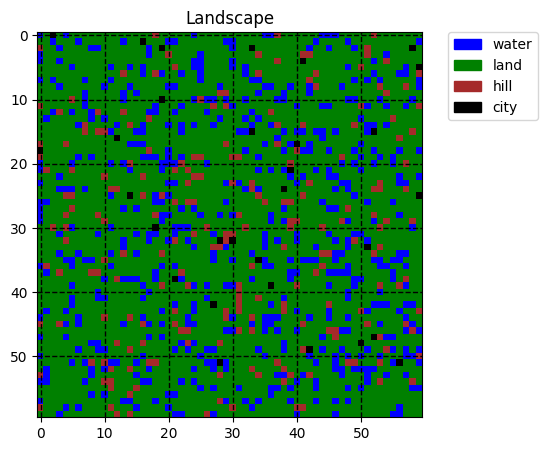

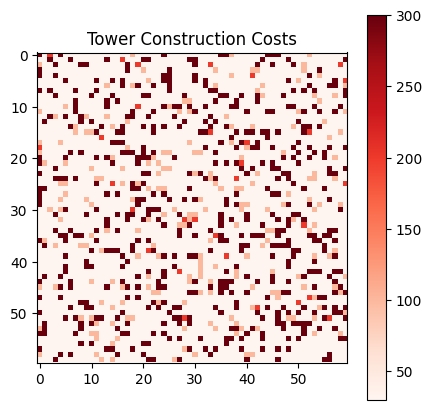

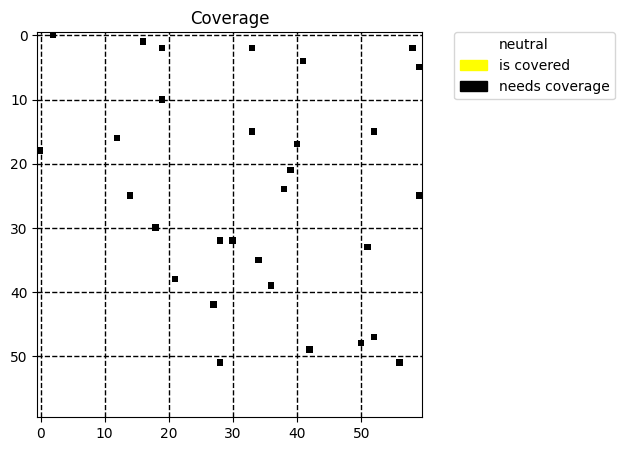

Coverage after setting up the cell towers:


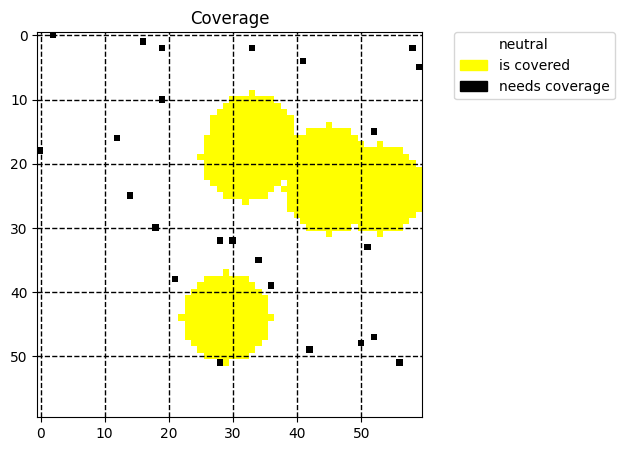

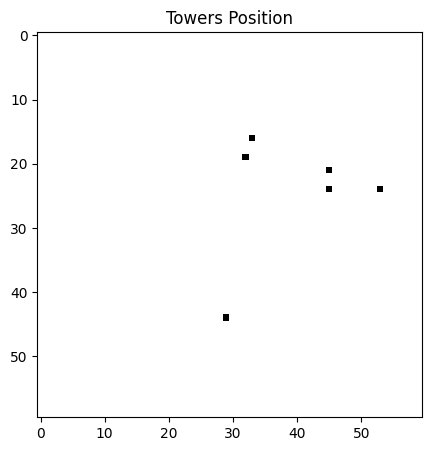

In [7]:
# the purpose of this line is to reproduce your results
random.seed(15)
random.random()

# map dimension:
rows = 60
cols = 60

square_grid = { 
    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,
    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
}

landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

Chromosome.rows = rows
Chromosome.cols = cols

# fitness function undefined yet 
def fitness_function(cr,worstCostOfPopulation,penalty=100): 
    return cr.cost-worstCostOfPopulation-cr.uncovered*penalty

Chromosome.set_fitness_function(fitness_function) 
cr = Chromosome.generate_random(.001)

test_landscape = copy.deepcopy(landscape) 
# coverage of 7km
test_landscape.add_towers(cr.get_coordinates(), 7)

towers = cr.count_towers() 
cr.uncovered = test_landscape.uncovered_count() 
cr.cost=test_landscape.costOfTowersAdded
F=cr.fitness_function(2000)
print(f'# F: {F}') 
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {cr.cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {cr.uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

In [31]:
def fitness_function(cr,cities,worstValueOfPopulation,buff=3000): 
    f=-cr.cost+worstValueOfPopulation+(cities-cr.uncovered)*buff
    
    return f
rows = 60
cols = 60
Chromosome.rows = rows
Chromosome.cols = cols
Chromosome.set_fitness_function(fitness_function) 
landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

def addSubstr(arr1,arr2,initIndex,endIndex):
    if(endIndex==-1):
        arr1+=arr2[initIndex::]
    else:
        arr1+=arr2[initIndex:endIndex]
    return arr1
def crossover(parent1, parent2,points=4,failProbability=0.3):
    parent1=parent1.gens
    parent2=parent2.gens
    if random.randint(0,1)<=failProbability:
        return parent1,parent2
    
    crossover_points=sorted(random.sample(range(len(parent1)), points))
    crossover_points.append(-1)
    child1=[]
    child2=[]
    order=0
    lastPoint=0
    for point in crossover_points:
        if order==0:
            addSubstr(child1,parent1,lastPoint,point)
            addSubstr(child2,parent2,lastPoint,point)
            order=1
        else:
            addSubstr(child1,parent2,lastPoint,point)
            addSubstr(child2,parent1,lastPoint,point)
            order=0
        lastPoint=point
    return child1,child2
def mutateGen(gens,mutationProb=0.1):
    if random.randint(0,1)>mutationProb:
        return gens
    genIndex=random.sample(range(len(gens)), 1)[0]
    if gens[genIndex]==0:
        gens[genIndex]=1
    else:
        gens[genIndex]=0
    return gens
def calculateCostAndUncovered(cr,landscape):
    landscapeCopy = copy.deepcopy(landscape) 
    landscapeCopy.add_towers(cr.get_coordinates(), 7)
    return  landscapeCopy.costOfTowersAdded,landscapeCopy.uncovered_count()
def geneticAlgorithm(landscape,cities,runTimes=200,P=20,probToGenerateTower=0.0001,penaltyPerCity=100):
    basePopulation=[]
    ansArray=[]
    for _ in range(P):
        newCr=Chromosome.generate_random(probToGenerateTower)
        basePopulation.append(newCr)
    for rt in range(runTimes):
        probabilities=[]
        worstValueOfPopulation=0
        FitnessOfPopulation=0
        bestPopulationChromosome=None
        for cr in basePopulation:
            cr.cost,cr.uncovered=calculateCostAndUncovered(cr,landscape)
            if cr.cost>worstValueOfPopulation:
                worstValueOfPopulation=cr.cost
        for cr in basePopulation:
            cr.FitnessValue=cr.fitness_function(cities,worstValueOfPopulation,penaltyPerCity)
            FitnessOfPopulation+=cr.FitnessValue
        if(FitnessOfPopulation==0):
            FitnessOfPopulation=1
        for cr in basePopulation:
            probabilities.append(cr.FitnessValue/FitnessOfPopulation)
        newPopulation=[]
        while len(newPopulation)!=P:
            cr1,cr2=np.random.choice(basePopulation,2,p=probabilities)
            crx,crz=crossover(cr1,cr2,2)
            crx=mutateGen(crx)
            crz=mutateGen(crz)
            
            newPopulation.append(Chromosome(crx))
            if(len(newPopulation)!=P):
                newPopulation.append(Chromosome(crz))
        bestPopulationChromosome=max(basePopulation)
        basePopulation=newPopulation
        print(rt,FitnessOfPopulation,bestPopulationChromosome.uncovered)
        ansArray.append((FitnessOfPopulation,bestPopulationChromosome.uncovered))
    return bestPopulationChromosome,ansArray
print("cities:",landscape.uncovered_count())
#bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count())
#print(bestGen.__dict__)

cities: 25


In [32]:
matrix=[]
runTimes=5
generations=200
P=20
for _ in range(runTimes):
    bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count(),generations,P)
    print("Finished run")
    matrix.append(arrayParaver)


0 5670 24
1 6570 23
2 8220 22
3 9860 20
4 10770 20
5 14930 19
6 21040 20
7 23910 20
8 24040 18
9 24740 20
10 24480 18
11 26750 18
12 29710 16
13 30440 16
14 31810 16
15 30490 16
16 22960 14
17 26220 13
18 28280 13
19 30520 11
20 30630 10
21 29730 14
22 30490 12
23 32320 12
24 31840 11
25 32630 12
26 36910 14
27 32710 10
28 34030 14
29 38660 8
30 40000 10
31 33160 10
32 35510 10
33 39610 10
34 37060 8
35 40240 8
36 38520 9
37 38120 9
38 39130 7
39 40250 6
40 40960 9
41 40610 12
42 42410 10
43 42810 7
44 45650 6
45 44580 4
46 47540 3
47 47830 5
48 47690 7
49 47680 7
50 47460 1
51 51670 2
52 48560 5
53 49600 5
54 53860 7
55 50680 7
56 52860 7
57 58850 5
58 63450 6
59 51930 6
60 51520 6
61 52220 6
62 58780 5
63 56720 5
64 54870 4
65 58480 4
66 56950 3
67 66500 4
68 70590 4
69 68750 4
70 61950 3
71 56550 3
72 52480 3
73 52640 3
74 53580 3
75 53620 4
76 59170 4
77 57630 2
78 56130 4
79 56160 1
80 55200 2
81 56020 2
82 58880 4
83 65490 3
84 65170 3
85 64010 2
86 66860 2
87 65790 4
88 55050 3


In [33]:
import pickle
 
def save_object(obj):
    try:
        with open("matrixWRuntimes.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
 
save_object(matrix)

In [34]:
AverageFitness=[]
AverageUncovered=[]
for generation in range(len(matrix[1])):
    valueAvg=0
    valueAvgUncovered=0
    for rT in range(runTimes):
        valueAvg+=matrix[rT][generation][0]
        valueAvgUncovered+=matrix[rT][generation][1]
    valueAvg=valueAvg/runTimes
    valueAvgUncovered=valueAvgUncovered/runTimes
    AverageFitness.append(valueAvg)
    AverageUncovered.append(valueAvgUncovered)
print(AverageFitness)
print(AverageUncovered)

[5008.0, 6340.0, 9366.0, 11502.0, 13112.0, 16432.0, 19130.0, 21398.0, 23918.0, 27410.0, 28678.0, 29684.0, 31638.0, 32772.0, 34308.0, 34762.0, 33520.0, 34986.0, 37098.0, 37920.0, 38606.0, 37644.0, 41536.0, 42376.0, 42082.0, 44044.0, 44632.0, 44870.0, 44170.0, 46624.0, 47416.0, 47204.0, 48976.0, 48414.0, 43116.0, 45312.0, 46180.0, 44780.0, 46442.0, 46690.0, 46850.0, 45568.0, 46594.0, 46938.0, 50102.0, 50250.0, 49200.0, 50636.0, 49972.0, 49386.0, 49636.0, 50672.0, 51586.0, 51184.0, 52440.0, 53012.0, 52968.0, 55676.0, 55424.0, 54810.0, 54090.0, 54084.0, 56278.0, 57890.0, 56366.0, 55744.0, 57266.0, 57562.0, 58744.0, 59238.0, 59628.0, 58526.0, 56190.0, 56608.0, 57442.0, 55594.0, 56230.0, 55218.0, 57012.0, 56900.0, 57376.0, 58092.0, 57018.0, 57668.0, 58016.0, 57726.0, 59826.0, 58342.0, 58512.0, 56270.0, 55472.0, 56940.0, 57294.0, 58070.0, 58120.0, 60256.0, 59452.0, 58326.0, 59560.0, 59422.0, 59446.0, 61040.0, 60192.0, 59674.0, 61668.0, 59756.0, 60036.0, 62476.0, 61476.0, 61886.0, 62800.0, 625

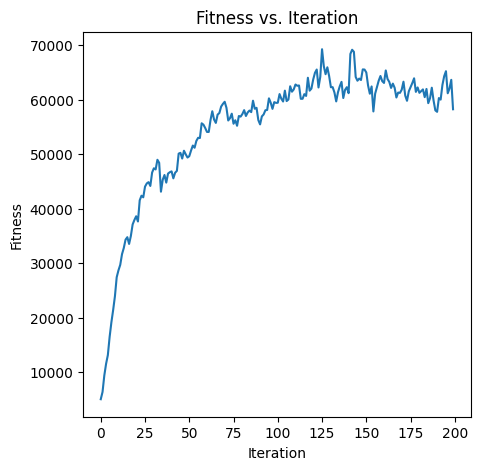

In [35]:
iterations = range(len(AverageFitness))
plt.plot(iterations, AverageFitness)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness vs. Iteration')
plt.show()

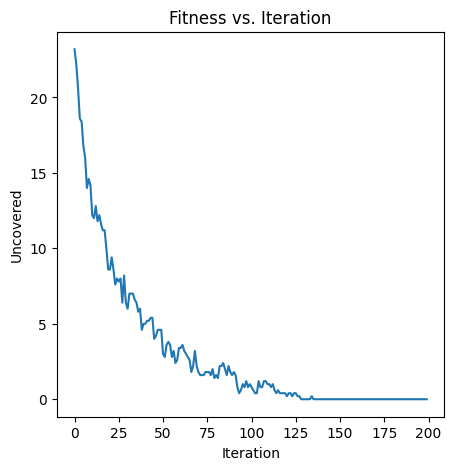

In [36]:
iterations = range(len(AverageUncovered))
plt.plot(iterations, AverageUncovered)
plt.xlabel('Iteration')
plt.ylabel('Uncovered')
plt.title('Fitness vs. Iteration')
plt.show()

{'gens': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

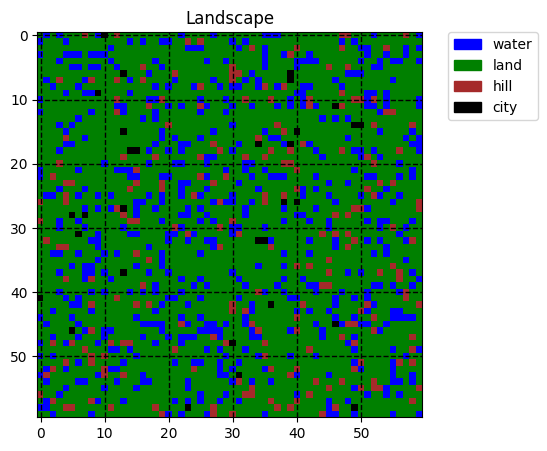

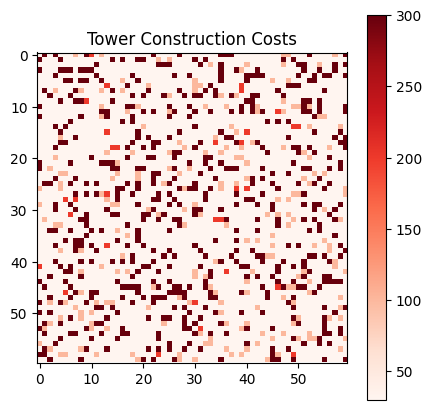

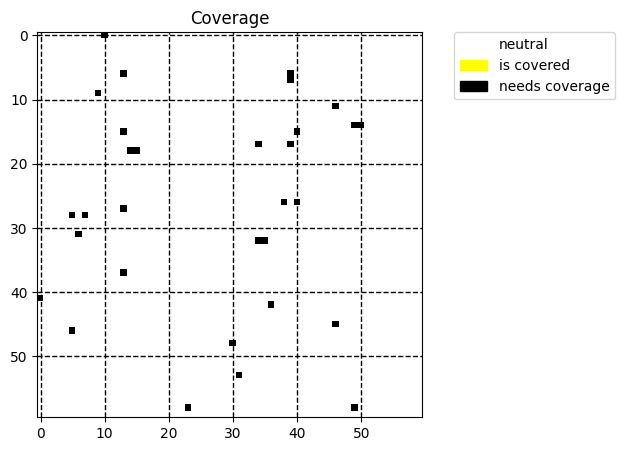

Coverage after setting up the cell towers:


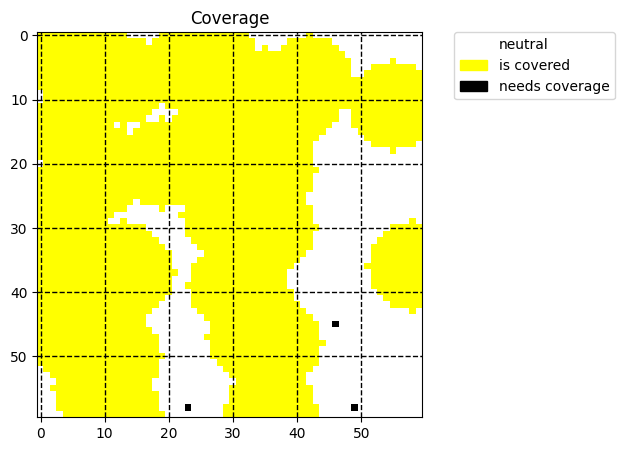

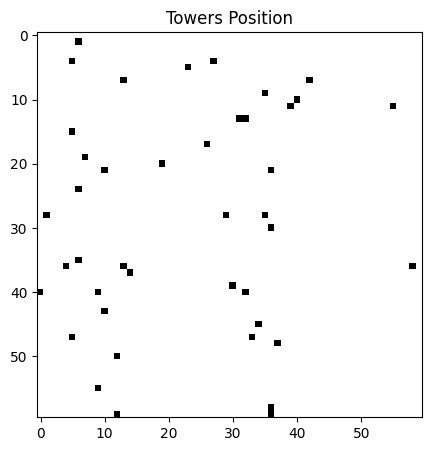

In [ ]:
print(bestGen.__dict__)
test_landscape = copy.deepcopy(landscape) 
test_landscape.add_towers(bestGen.get_coordinates(), 7)
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {bestGen.cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {bestGen.uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

## Tasks

1. Explain how you plan to use genetic algorithms to solve this problem and how your solution will work.
2. Implement a genetic algorithm to solve the problem. Plot the average fitness of the population for each generation.
3. Use different settings for the algorithm parameters (such as $p_c$, $p_m$, size of the population), report and disscuss your results. 
4. How does your solution look like? How many cell towers we need to use? What is the total cost of installing all of these? 